<a href="https://colab.research.google.com/github/MrCogito/Spectrogram-Generator/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import TensorFlow and other libraries



In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt 
import pathlib
import os
from google.colab import drive
import time
import librosa
import librosa.display




In [ ]:
drive.mount('/content/gdrive') #Mount google driv

Mounted at /content/gdrive


In [ ]:
tf.__version__

'2.7.0'

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))



Found GPU at: /device:GPU:0


# Load and prepare the dataset

float32
(12196, 256, 14)
1.0000001
-1.0
(12196, 256, 14, 1)


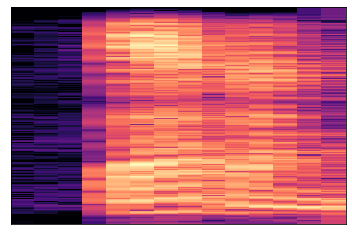

In [ ]:
# Load data

data_tensor = np.load('/content/gdrive/MyDrive/Inzynierka/Data/en_spectrogram_tensor/Dataset_spectrogram_256_14.npy')
#print(data_tensor)
print(data_tensor.dtype)
print(data_tensor.shape)
librosa.display.specshow(data_tensor[3])
data_tensor = (data_tensor + 40) / 40
#print(data_tensor.shape)
print(np.max(data_tensor))
print(np.min(data_tensor))
data_tensor = data_tensor.reshape(12196, 256, 14, 1)
print(data_tensor.shape)
BUFFER_SIZE = 12196
BATCH_SIZE = 128

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(data_tensor).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)



# Build the generator

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*7*128, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.3))

    model.add(layers.Reshape((8, 7, 128)))
    assert model.output_shape == (None, 8, 7, 128)  # ensure size is correct None is batch size
   
   
    model.add(layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"))
    print(model.output_shape)
    assert model.output_shape == (None, 16, 14, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.3))
    
    model.add(layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"))
    print(model.output_shape)
    assert model.output_shape == (None, 32, 28, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.3))

    model.add(layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"))
    print(model.output_shape)
    assert model.output_shape == (None, 64, 56, 512)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.3))
    
    model.add(layers.Conv2D(1, kernel_size=5, padding="same", activation="sigmoid"))
    print(model.output_shape)
    model.add(layers.Reshape((256,14,1)))
    print(model.output_shape)
    return model





In [ ]:
generator = make_generator_model()
generator.summary()

(None, 16, 14, 128)
(None, 32, 28, 256)
(None, 64, 56, 512)
(None, 64, 56, 1)
(None, 256, 14, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 7168)              716800    
                                                                 
 batch_normalization (BatchN  (None, 7168)             28672     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 7168)              0         
                                                                 
 reshape (Reshape)           (None, 8, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 14, 128)      262272    
 nspose)                                                         
                         

(1, 256, 14, 1)


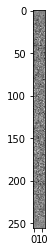

In [ ]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
print(generated_image.shape)

# Build the discriminator


In [ ]:
def make_discriminator_model():
  
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, kernel_size=4, strides=2, padding='same',input_shape=[256, 14, 1]))
  model.add(layers.LeakyReLU(alpha=0.3))

  model.add(layers.Conv2D(128, (5,5), strides=(2, 2), padding='same'))
  model.add(layers.LeakyReLU(alpha=0.3))
  model.add(layers.Dropout(0.5))



  model.add(layers.Flatten())
  model.add(layers.Dense(1))

  return model



In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)
discriminator.summary()

tf.Tensor([[0.04294949]], shape=(1, 1), dtype=float32)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 128, 7, 64)        1088      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 128, 7, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 4, 128)        204928    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 64, 4, 128)        0         
                                                                 
 dropout (Dropout)           (None, 64, 4, 128)        0         
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 

# Define the loss and optimizers


In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True) # from_logits=True return value in [-inf, inf]

In [ ]:
#discriminator loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    total_loss = real_loss + fake_loss
    return total_loss, fake_loss, real_loss
    

In [ ]:
#generator loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
#optimizers 
generator_optimizer = tf.keras.optimizers.Adam(0.0002)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0001)

# Save checkpoints


In [ ]:
checkpoint_dir = '/content/gdrive/MyDrive/Inzynierka/Data/Results/v5/checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Save and plot history

In [ ]:
def plot_history(d1_hist, g_hist,epochs):
  # plot loss
	plt.subplot(2,1,1)
	plt.plot(d1_hist, label='disc loss')
	plt.legend()
	plt.subplot(2,1,2)
	plt.plot(g_hist, label='gen loss')
	plt.legend()
	#plt.show()
	# plot discriminator accuracy
	# save plot to file
	plt.savefig('/content/gdrive/MyDrive/Inzynierka/Data/Results/v5/DG_loss' + str(epochs))
	plt.close()

In [ ]:
def plot_history2(dfake_hist, dreal_hist,epochs):
  # plot loss
	plt.subplot(2,1,1)
	plt.plot(dfake_hist, label='dfake_hist')
	plt.legend()
	plt.subplot(2,1,2)
	plt.plot(dreal_hist, label='dreal_hist')
	plt.legend()
	#plt.show()
	# plot discriminator accuracy
	# save plot to file
	plt.savefig('/content/gdrive/MyDrive/Inzynierka/Data/Results/v5/discriminator_loss' + str(epochs))
	plt.close()

# Define the training loop

In [ ]:
EPOCHS = 500
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
# to moze byc do wywalenia
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss, fake_loss, real_loss = discriminator_loss(real_output, fake_output)


    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss, fake_loss, real_loss


In [ ]:
def train(dataset, epochs):
  generator_hist, discriminator_hist, discriminator_fake_hist, discriminator_real_hist  = list(), list(), list(), list()
  for epoch in range(epochs):
    start = time.time()
    #
    disc_loss,gen_loss,fake_loss,real_loss = 0,0,0,0
    #
    for image_batch in dataset:
      gen_loss_change,disc_loss_change, fake_loss_change, real_loss_change = train_step(image_batch)
      gen_loss = gen_loss + gen_loss_change
      disc_loss = disc_loss + disc_loss_change
      fake_loss = fake_loss + fake_loss_change
      real_loss = real_loss + real_loss_change
    # Produce images for the GIF as you go
    #display.clear_output(wait=True)
    #generate_and_save_images(generator,
                             #epoch + 1,
                             #seed)
    # save generator and discriminator loss values 
    discriminator_hist.append(disc_loss)
    generator_hist.append(gen_loss)
    discriminator_fake_hist.append(fake_loss)
    discriminator_real_hist.append(real_loss)

    # Save the model every 10 epochs
    if (epoch) % 25 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
      plot_history(discriminator_hist,generator_hist,epoch)
      plot_history2(discriminator_fake_hist,discriminator_real_hist,epoch)
      generate_and_save_images(generator,epoch,seed)
      print("Generated and saved")
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  #display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [ ]:
#Generate and save images 
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()
  np.save("/content/gdrive/MyDrive/Inzynierka/Data/Results/v4/v4_" + str(epoch), predictions)
  print(predictions.shape)
  

# Train model

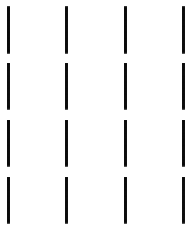

(16, 256, 14, 1)
Generated and saved
Time for epoch 1 is 45.39366817474365 sec
Time for epoch 2 is 28.11924433708191 sec
Time for epoch 3 is 28.441009283065796 sec
Time for epoch 4 is 28.40450119972229 sec
Time for epoch 5 is 28.426074981689453 sec
Time for epoch 6 is 28.40981936454773 sec
Time for epoch 7 is 28.39408779144287 sec
Time for epoch 8 is 28.392204761505127 sec
Time for epoch 9 is 28.40683126449585 sec
Time for epoch 10 is 28.403982400894165 sec
Time for epoch 11 is 28.3910493850708 sec
Time for epoch 12 is 28.403868436813354 sec
Time for epoch 13 is 28.401143312454224 sec
Time for epoch 14 is 28.38010811805725 sec
Time for epoch 15 is 28.4000244140625 sec
Time for epoch 16 is 28.390010118484497 sec
Time for epoch 17 is 28.38241195678711 sec
Time for epoch 18 is 28.376095294952393 sec
Time for epoch 19 is 28.39092779159546 sec
Time for epoch 20 is 28.3815336227417 sec
Time for epoch 21 is 28.388100385665894 sec
Time for epoch 22 is 28.388872623443604 sec
Time for epoch 23 i

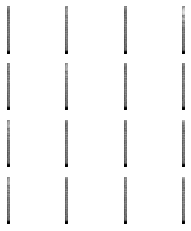

(16, 256, 14, 1)
Generated and saved
Time for epoch 26 is 31.70720076560974 sec
Time for epoch 27 is 28.21299171447754 sec
Time for epoch 28 is 28.373055696487427 sec
Time for epoch 29 is 28.394470691680908 sec
Time for epoch 30 is 28.36076784133911 sec
Time for epoch 31 is 28.380997896194458 sec
Time for epoch 32 is 28.375758171081543 sec
Time for epoch 33 is 28.36646270751953 sec
Time for epoch 34 is 28.352876663208008 sec
Time for epoch 35 is 28.359820127487183 sec
Time for epoch 36 is 28.36467409133911 sec
Time for epoch 37 is 28.378043174743652 sec
Time for epoch 38 is 28.358068466186523 sec
Time for epoch 39 is 28.35581111907959 sec
Time for epoch 40 is 28.38383913040161 sec
Time for epoch 41 is 28.37850022315979 sec
Time for epoch 42 is 28.365397214889526 sec
Time for epoch 43 is 28.363253831863403 sec
Time for epoch 44 is 28.344605445861816 sec
Time for epoch 45 is 28.36573839187622 sec
Time for epoch 46 is 28.361397981643677 sec
Time for epoch 47 is 28.34251308441162 sec
Time 

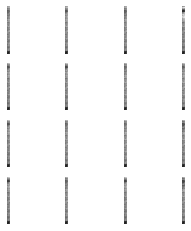

(16, 256, 14, 1)
Generated and saved
Time for epoch 51 is 31.890187740325928 sec
Time for epoch 52 is 28.212405920028687 sec
Time for epoch 53 is 28.38365650177002 sec
Time for epoch 54 is 28.362081289291382 sec
Time for epoch 55 is 28.363168478012085 sec
Time for epoch 56 is 28.366973638534546 sec
Time for epoch 57 is 28.33812117576599 sec
Time for epoch 58 is 28.346453189849854 sec
Time for epoch 59 is 28.34820032119751 sec
Time for epoch 60 is 28.35884714126587 sec
Time for epoch 61 is 28.3643696308136 sec
Time for epoch 62 is 28.34631657600403 sec
Time for epoch 63 is 28.36398196220398 sec
Time for epoch 64 is 28.366518020629883 sec
Time for epoch 65 is 28.3487331867218 sec
Time for epoch 66 is 28.35366153717041 sec
Time for epoch 67 is 28.35534381866455 sec
Time for epoch 68 is 28.350789070129395 sec
Time for epoch 69 is 28.34169363975525 sec
Time for epoch 70 is 28.358046054840088 sec
Time for epoch 71 is 28.354813814163208 sec
Time for epoch 72 is 28.362355947494507 sec
Time for

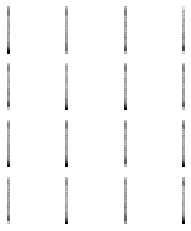

(16, 256, 14, 1)
Generated and saved
Time for epoch 76 is 29.847980499267578 sec
Time for epoch 77 is 28.186962604522705 sec
Time for epoch 78 is 28.37821125984192 sec
Time for epoch 79 is 28.369441747665405 sec
Time for epoch 80 is 28.357695817947388 sec
Time for epoch 81 is 28.349223136901855 sec
Time for epoch 82 is 28.657134532928467 sec
Time for epoch 83 is 28.176871061325073 sec
Time for epoch 84 is 28.329479217529297 sec
Time for epoch 85 is 28.34601855278015 sec
Time for epoch 86 is 28.347742319107056 sec
Time for epoch 87 is 28.357422828674316 sec
Time for epoch 88 is 28.345010995864868 sec
Time for epoch 89 is 28.350632905960083 sec
Time for epoch 90 is 28.352439641952515 sec
Time for epoch 91 is 28.355865240097046 sec
Time for epoch 92 is 28.36442756652832 sec
Time for epoch 93 is 28.341778993606567 sec
Time for epoch 94 is 28.350633144378662 sec
Time for epoch 95 is 28.354161739349365 sec
Time for epoch 96 is 28.345739603042603 sec
Time for epoch 97 is 28.351049423217773 se

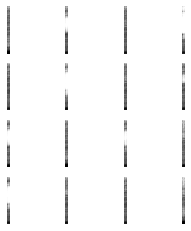

(16, 256, 14, 1)
Generated and saved
Time for epoch 101 is 29.85765528678894 sec
Time for epoch 102 is 28.178155422210693 sec
Time for epoch 103 is 28.35602641105652 sec
Time for epoch 104 is 28.35403537750244 sec
Time for epoch 105 is 28.356441974639893 sec
Time for epoch 106 is 28.35303282737732 sec
Time for epoch 107 is 28.352097749710083 sec
Time for epoch 108 is 28.354076862335205 sec
Time for epoch 109 is 28.353997230529785 sec
Time for epoch 110 is 28.34335446357727 sec
Time for epoch 111 is 28.349975109100342 sec
Time for epoch 112 is 28.344515085220337 sec
Time for epoch 113 is 28.367563247680664 sec
Time for epoch 114 is 28.32339835166931 sec
Time for epoch 115 is 28.357362508773804 sec
Time for epoch 116 is 28.344077348709106 sec
Time for epoch 117 is 28.347665786743164 sec
Time for epoch 118 is 28.34918475151062 sec
Time for epoch 119 is 28.337454080581665 sec
Time for epoch 120 is 28.346992015838623 sec
Time for epoch 121 is 28.352983474731445 sec
Time for epoch 122 is 28.

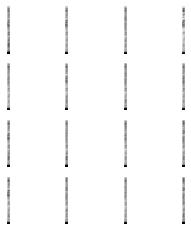

(16, 256, 14, 1)
Generated and saved
Time for epoch 126 is 30.069615840911865 sec
Time for epoch 127 is 28.170735597610474 sec
Time for epoch 128 is 28.33476948738098 sec
Time for epoch 129 is 28.34293293952942 sec
Time for epoch 130 is 28.334920406341553 sec
Time for epoch 131 is 28.34769105911255 sec
Time for epoch 132 is 28.327414989471436 sec
Time for epoch 133 is 28.35043692588806 sec
Time for epoch 134 is 28.335065126419067 sec
Time for epoch 135 is 28.338926553726196 sec
Time for epoch 136 is 28.34566569328308 sec
Time for epoch 137 is 28.332079648971558 sec
Time for epoch 138 is 28.333510875701904 sec
Time for epoch 139 is 28.330474853515625 sec
Time for epoch 140 is 28.33275556564331 sec
Time for epoch 141 is 28.317471742630005 sec
Time for epoch 142 is 28.335352897644043 sec
Time for epoch 143 is 28.333218812942505 sec
Time for epoch 144 is 28.319080352783203 sec
Time for epoch 145 is 28.33441424369812 sec
Time for epoch 146 is 28.321770191192627 sec
Time for epoch 147 is 28.

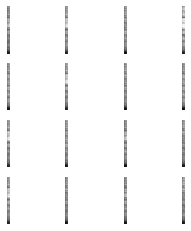

(16, 256, 14, 1)
Generated and saved
Time for epoch 151 is 29.871917486190796 sec
Time for epoch 152 is 28.158888578414917 sec
Time for epoch 153 is 28.324700832366943 sec
Time for epoch 154 is 28.331997394561768 sec
Time for epoch 155 is 28.325934410095215 sec
Time for epoch 156 is 28.328129768371582 sec
Time for epoch 157 is 28.322482109069824 sec
Time for epoch 158 is 28.32675790786743 sec
Time for epoch 159 is 28.3086519241333 sec
Time for epoch 160 is 28.334992170333862 sec
Time for epoch 161 is 28.332361936569214 sec
Time for epoch 162 is 28.32469868659973 sec
Time for epoch 163 is 28.3056423664093 sec
Time for epoch 164 is 28.326939344406128 sec
Time for epoch 165 is 28.319878578186035 sec
Time for epoch 166 is 28.30267333984375 sec
Time for epoch 167 is 28.33326816558838 sec
Time for epoch 168 is 28.314429759979248 sec
Time for epoch 169 is 28.325793027877808 sec
Time for epoch 170 is 28.30241870880127 sec
Time for epoch 171 is 28.34439206123352 sec
Time for epoch 172 is 28.333

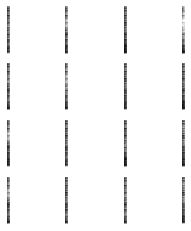

(16, 256, 14, 1)
Generated and saved
Time for epoch 176 is 29.87062978744507 sec
Time for epoch 177 is 28.154191255569458 sec
Time for epoch 178 is 28.344688415527344 sec
Time for epoch 179 is 28.328104972839355 sec
Time for epoch 180 is 28.330963850021362 sec
Time for epoch 181 is 28.31691336631775 sec
Time for epoch 182 is 28.319828748703003 sec
Time for epoch 183 is 28.311896085739136 sec
Time for epoch 184 is 28.328670263290405 sec
Time for epoch 185 is 28.309728145599365 sec
Time for epoch 186 is 28.31315302848816 sec
Time for epoch 187 is 28.303938388824463 sec
Time for epoch 188 is 28.322102546691895 sec
Time for epoch 189 is 28.333909511566162 sec
Time for epoch 190 is 28.32008981704712 sec
Time for epoch 191 is 28.326583862304688 sec
Time for epoch 192 is 28.317490339279175 sec
Time for epoch 193 is 28.331116676330566 sec
Time for epoch 194 is 28.323718309402466 sec
Time for epoch 195 is 28.316579818725586 sec
Time for epoch 196 is 28.601966619491577 sec
Time for epoch 197 is 

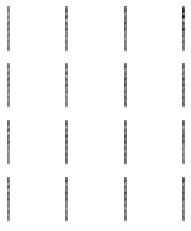

(16, 256, 14, 1)
Generated and saved
Time for epoch 201 is 30.116190910339355 sec
Time for epoch 202 is 28.1604163646698 sec
Time for epoch 203 is 28.33738875389099 sec
Time for epoch 204 is 28.336514472961426 sec
Time for epoch 205 is 28.33715271949768 sec
Time for epoch 206 is 28.337687015533447 sec
Time for epoch 207 is 28.33220338821411 sec
Time for epoch 208 is 28.312150478363037 sec
Time for epoch 209 is 28.324007511138916 sec
Time for epoch 210 is 28.333380699157715 sec
Time for epoch 211 is 28.3160502910614 sec
Time for epoch 212 is 28.338731288909912 sec
Time for epoch 213 is 28.32529616355896 sec
Time for epoch 214 is 28.35607147216797 sec
Time for epoch 215 is 28.329837560653687 sec
Time for epoch 216 is 28.33168077468872 sec
Time for epoch 217 is 28.32528829574585 sec
Time for epoch 218 is 28.321065664291382 sec
Time for epoch 219 is 28.348464012145996 sec
Time for epoch 220 is 28.327243328094482 sec
Time for epoch 221 is 28.340842485427856 sec
Time for epoch 222 is 28.3228

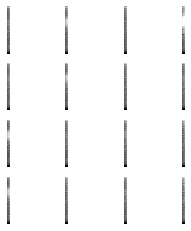

(16, 256, 14, 1)
Generated and saved
Time for epoch 226 is 29.878942012786865 sec
Time for epoch 227 is 28.14999222755432 sec
Time for epoch 228 is 28.32935929298401 sec
Time for epoch 229 is 28.31781530380249 sec
Time for epoch 230 is 28.320034742355347 sec
Time for epoch 231 is 28.33606243133545 sec
Time for epoch 232 is 28.338376760482788 sec
Time for epoch 233 is 28.325364351272583 sec
Time for epoch 234 is 28.321555614471436 sec
Time for epoch 235 is 28.323310613632202 sec
Time for epoch 236 is 28.323546409606934 sec
Time for epoch 237 is 28.326167345046997 sec
Time for epoch 238 is 28.32867693901062 sec
Time for epoch 239 is 28.3104510307312 sec
Time for epoch 240 is 28.31501841545105 sec
Time for epoch 241 is 28.326447248458862 sec
Time for epoch 242 is 28.31742811203003 sec
Time for epoch 243 is 28.311234951019287 sec
Time for epoch 244 is 28.343912363052368 sec
Time for epoch 245 is 28.32245135307312 sec
Time for epoch 246 is 28.290165424346924 sec
Time for epoch 247 is 28.319

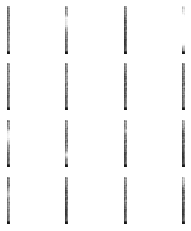

(16, 256, 14, 1)
Generated and saved
Time for epoch 251 is 29.87533736228943 sec
Time for epoch 252 is 28.15987515449524 sec
Time for epoch 253 is 28.319398164749146 sec
Time for epoch 254 is 28.304999113082886 sec
Time for epoch 255 is 28.322624683380127 sec
Time for epoch 256 is 28.327475786209106 sec
Time for epoch 257 is 28.298639059066772 sec
Time for epoch 258 is 28.30722713470459 sec
Time for epoch 259 is 28.32382869720459 sec
Time for epoch 260 is 28.316641330718994 sec
Time for epoch 261 is 28.29612970352173 sec
Time for epoch 262 is 28.323777675628662 sec
Time for epoch 263 is 28.324156284332275 sec
Time for epoch 264 is 28.303954362869263 sec
Time for epoch 265 is 28.319156169891357 sec
Time for epoch 266 is 28.317216396331787 sec
Time for epoch 267 is 28.301704168319702 sec
Time for epoch 268 is 28.317930936813354 sec
Time for epoch 269 is 28.326390981674194 sec
Time for epoch 270 is 28.308566093444824 sec
Time for epoch 271 is 28.310584545135498 sec
Time for epoch 272 is 2

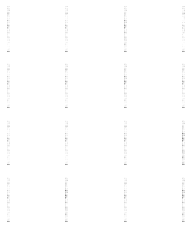

(16, 256, 14, 1)
Generated and saved
Time for epoch 276 is 30.14030385017395 sec
Time for epoch 277 is 28.1529061794281 sec
Time for epoch 278 is 28.308202743530273 sec
Time for epoch 279 is 28.3046133518219 sec
Time for epoch 280 is 28.32619071006775 sec
Time for epoch 281 is 28.319066286087036 sec
Time for epoch 282 is 28.324394941329956 sec
Time for epoch 283 is 28.313086986541748 sec
Time for epoch 284 is 28.320188760757446 sec
Time for epoch 285 is 28.29701828956604 sec
Time for epoch 286 is 28.314836025238037 sec
Time for epoch 287 is 28.311285495758057 sec
Time for epoch 288 is 28.325751543045044 sec
Time for epoch 289 is 28.311237573623657 sec
Time for epoch 290 is 28.313398122787476 sec
Time for epoch 291 is 28.30642080307007 sec
Time for epoch 292 is 28.319194555282593 sec
Time for epoch 293 is 28.340580701828003 sec
Time for epoch 294 is 28.309387922286987 sec
Time for epoch 295 is 28.314246654510498 sec
Time for epoch 296 is 28.318779945373535 sec
Time for epoch 297 is 28.2

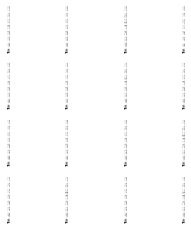

(16, 256, 14, 1)
Generated and saved
Time for epoch 301 is 29.88728356361389 sec
Time for epoch 302 is 28.140991687774658 sec
Time for epoch 303 is 28.347107887268066 sec
Time for epoch 304 is 28.324469804763794 sec
Time for epoch 305 is 28.59606432914734 sec
Time for epoch 306 is 28.14775061607361 sec
Time for epoch 307 is 28.319913148880005 sec
Time for epoch 308 is 28.317196369171143 sec
Time for epoch 309 is 28.31615447998047 sec
Time for epoch 310 is 28.30670475959778 sec
Time for epoch 311 is 28.467077016830444 sec
Time for epoch 312 is 28.16108012199402 sec
Time for epoch 313 is 28.299379348754883 sec
Time for epoch 314 is 28.316946744918823 sec
Time for epoch 315 is 28.30617046356201 sec
Time for epoch 316 is 28.331974267959595 sec
Time for epoch 317 is 28.308398962020874 sec
Time for epoch 318 is 28.319649934768677 sec
Time for epoch 319 is 28.32883930206299 sec
Time for epoch 320 is 28.325233459472656 sec
Time for epoch 321 is 28.317952871322632 sec
Time for epoch 322 is 28.3

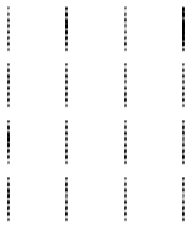

(16, 256, 14, 1)
Generated and saved
Time for epoch 326 is 29.915382862091064 sec
Time for epoch 327 is 28.1434805393219 sec
Time for epoch 328 is 28.308956384658813 sec
Time for epoch 329 is 28.318592071533203 sec
Time for epoch 330 is 28.319101333618164 sec
Time for epoch 331 is 28.30724596977234 sec
Time for epoch 332 is 28.307077884674072 sec
Time for epoch 333 is 28.324726343154907 sec
Time for epoch 334 is 28.330241441726685 sec
Time for epoch 335 is 28.308090925216675 sec
Time for epoch 336 is 28.319273471832275 sec
Time for epoch 337 is 28.314866304397583 sec
Time for epoch 338 is 28.316240549087524 sec
Time for epoch 339 is 28.31117010116577 sec
Time for epoch 340 is 28.326587200164795 sec
Time for epoch 341 is 28.315572023391724 sec
Time for epoch 342 is 28.310261011123657 sec
Time for epoch 343 is 28.308610200881958 sec
Time for epoch 344 is 28.31511878967285 sec
Time for epoch 345 is 28.300362825393677 sec
Time for epoch 346 is 28.30601143836975 sec
Time for epoch 347 is 28

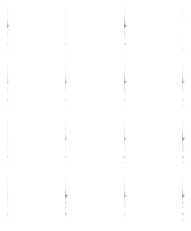

(16, 256, 14, 1)
Generated and saved
Time for epoch 351 is 30.119718551635742 sec
Time for epoch 352 is 28.170162200927734 sec
Time for epoch 353 is 28.321077346801758 sec
Time for epoch 354 is 28.32839608192444 sec
Time for epoch 355 is 28.31704068183899 sec
Time for epoch 356 is 28.31462049484253 sec
Time for epoch 357 is 28.305098295211792 sec
Time for epoch 358 is 28.315131664276123 sec
Time for epoch 359 is 28.316522359848022 sec
Time for epoch 360 is 28.32038426399231 sec
Time for epoch 361 is 28.30851173400879 sec
Time for epoch 362 is 28.30030369758606 sec
Time for epoch 363 is 28.299144983291626 sec
Time for epoch 364 is 28.295220375061035 sec
Time for epoch 365 is 28.30485773086548 sec
Time for epoch 366 is 28.326173543930054 sec
Time for epoch 367 is 28.31313180923462 sec
Time for epoch 368 is 28.59977960586548 sec
Time for epoch 369 is 28.121573209762573 sec
Time for epoch 370 is 28.297844886779785 sec
Time for epoch 371 is 28.30634307861328 sec
Time for epoch 372 is 28.306

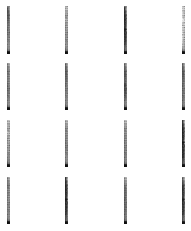

(16, 256, 14, 1)
Generated and saved
Time for epoch 376 is 29.937413692474365 sec
Time for epoch 377 is 28.12852716445923 sec
Time for epoch 378 is 28.32351279258728 sec
Time for epoch 379 is 28.303659677505493 sec
Time for epoch 380 is 28.304129362106323 sec
Time for epoch 381 is 28.297828674316406 sec
Time for epoch 382 is 28.30276584625244 sec
Time for epoch 383 is 28.31228804588318 sec
Time for epoch 384 is 28.308277130126953 sec
Time for epoch 385 is 28.30907368659973 sec
Time for epoch 386 is 28.314040184020996 sec
Time for epoch 387 is 28.301403284072876 sec
Time for epoch 388 is 28.31701636314392 sec
Time for epoch 389 is 28.299612998962402 sec
Time for epoch 390 is 28.301296949386597 sec
Time for epoch 391 is 28.32223081588745 sec
Time for epoch 392 is 28.314651489257812 sec
Time for epoch 393 is 28.305955171585083 sec
Time for epoch 394 is 28.308629035949707 sec
Time for epoch 395 is 28.313426971435547 sec
Time for epoch 396 is 28.29852867126465 sec
Time for epoch 397 is 28.2

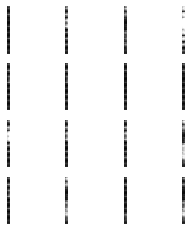

(16, 256, 14, 1)
Generated and saved
Time for epoch 401 is 29.90802240371704 sec
Time for epoch 402 is 28.135420560836792 sec
Time for epoch 403 is 28.307344675064087 sec
Time for epoch 404 is 28.314172744750977 sec
Time for epoch 405 is 28.303749322891235 sec
Time for epoch 406 is 28.300296306610107 sec
Time for epoch 407 is 28.29462480545044 sec
Time for epoch 408 is 28.294239282608032 sec
Time for epoch 409 is 28.316730260849 sec
Time for epoch 410 is 28.284043788909912 sec
Time for epoch 411 is 28.308938026428223 sec
Time for epoch 412 is 28.305415391921997 sec
Time for epoch 413 is 28.308820962905884 sec
Time for epoch 414 is 28.30655550956726 sec
Time for epoch 415 is 28.28009033203125 sec
Time for epoch 416 is 28.298824548721313 sec
Time for epoch 417 is 28.30386710166931 sec
Time for epoch 418 is 28.291664361953735 sec
Time for epoch 419 is 28.275279760360718 sec
Time for epoch 420 is 28.299777269363403 sec
Time for epoch 421 is 28.302114963531494 sec
Time for epoch 422 is 28.3

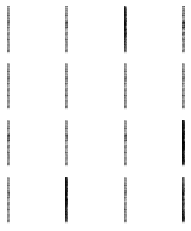

(16, 256, 14, 1)
Generated and saved
Time for epoch 426 is 30.154705047607422 sec
Time for epoch 427 is 28.129478454589844 sec
Time for epoch 428 is 28.312023639678955 sec
Time for epoch 429 is 28.32582116127014 sec
Time for epoch 430 is 28.28951907157898 sec
Time for epoch 431 is 28.301794290542603 sec
Time for epoch 432 is 28.3218252658844 sec
Time for epoch 433 is 28.302950620651245 sec
Time for epoch 434 is 28.29038429260254 sec
Time for epoch 435 is 28.319153308868408 sec
Time for epoch 436 is 28.30017590522766 sec
Time for epoch 437 is 28.311183214187622 sec
Time for epoch 438 is 28.307538986206055 sec
Time for epoch 439 is 28.309491872787476 sec
Time for epoch 440 is 28.442296743392944 sec
Time for epoch 441 is 28.15551447868347 sec
Time for epoch 442 is 28.29509162902832 sec
Time for epoch 443 is 28.31231951713562 sec
Time for epoch 444 is 28.441229581832886 sec
Time for epoch 445 is 28.16022229194641 sec
Time for epoch 446 is 28.29993224143982 sec
Time for epoch 447 is 28.3128

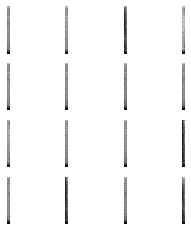

(16, 256, 14, 1)
Generated and saved
Time for epoch 451 is 29.854292154312134 sec
Time for epoch 452 is 28.14989471435547 sec
Time for epoch 453 is 28.318549394607544 sec
Time for epoch 454 is 28.301774263381958 sec
Time for epoch 455 is 28.298644065856934 sec
Time for epoch 456 is 28.3086941242218 sec
Time for epoch 457 is 28.323549509048462 sec
Time for epoch 458 is 28.31075119972229 sec
Time for epoch 459 is 28.28797698020935 sec
Time for epoch 460 is 28.30588126182556 sec
Time for epoch 461 is 28.306575775146484 sec
Time for epoch 462 is 28.29706835746765 sec
Time for epoch 463 is 28.31566286087036 sec
Time for epoch 464 is 28.294312477111816 sec
Time for epoch 465 is 28.326868295669556 sec
Time for epoch 466 is 28.295698165893555 sec
Time for epoch 467 is 28.29935121536255 sec
Time for epoch 468 is 28.284807205200195 sec
Time for epoch 469 is 28.306649923324585 sec
Time for epoch 470 is 28.301419258117676 sec
Time for epoch 471 is 28.299799919128418 sec
Time for epoch 472 is 28.30

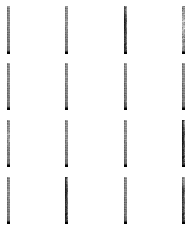

(16, 256, 14, 1)
Generated and saved
Time for epoch 476 is 29.82332730293274 sec
Time for epoch 477 is 28.122158527374268 sec
Time for epoch 478 is 28.317038536071777 sec
Time for epoch 479 is 28.330586194992065 sec
Time for epoch 480 is 28.3085880279541 sec
Time for epoch 481 is 28.321775913238525 sec
Time for epoch 482 is 28.30619788169861 sec
Time for epoch 483 is 28.320292711257935 sec
Time for epoch 484 is 28.300052642822266 sec
Time for epoch 485 is 28.304136276245117 sec
Time for epoch 486 is 28.337905168533325 sec
Time for epoch 487 is 28.301302671432495 sec
Time for epoch 488 is 28.303192615509033 sec
Time for epoch 489 is 28.292921781539917 sec
Time for epoch 490 is 28.2949640750885 sec
Time for epoch 491 is 28.311814069747925 sec
Time for epoch 492 is 28.313927173614502 sec
Time for epoch 493 is 28.30963969230652 sec
Time for epoch 494 is 28.320353031158447 sec
Time for epoch 495 is 28.301862955093384 sec
Time for epoch 496 is 28.301734924316406 sec
Time for epoch 497 is 28.

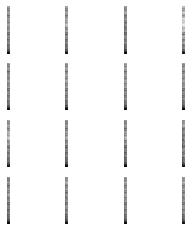

(16, 256, 14, 1)


In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
generate_and_save_images(generator, 60, seed)

In [ ]:
import librosa
import librosa.display
zaladowane = np.load('/content/gdrive/MyDrive/Inzynierka/Data/Results/v1/v1_259.npy')
#zaladowane = np.load('/content/gdrive/MyDrive/Inzynierka/Data/en_spectrogram_tensor/common_voice_en_22677141.mp3.npy')
print(zaladowane.shape)
#print(zaladowane[6])
print(np.max(zaladowane))
print(np.min(zaladowane))
normalized = (zaladowane * 80) - 80
print(np.max(normalized))
print(np.min(normalized))

#librosa.display.specshow(spectest)
#librosa.display.specshow((zaladowane[4].reshape(256,14)))
librosa.display.specshow((normalized[12].reshape(256,14)))
#print(normalized[2])

In [ ]:

librosa.display.specshow((normalized[4].reshape(256,14)))
print(normalized[1])

In [ ]:






print(data_tensor.shape)
spectest = zaladowane[1]
spectest = spectest.reshape(256,16)
spectest = (spectest*127.5)
print(spectest)
librosa.display.specshow(spectest)

In [ ]:
# To restore checkpoint
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
